# ToDo List!
* ¿Por qué normalizamos usando z-score? ¿Cuándo normalizamos? ¿Sólo variables continuas o discretas también?
* ¿Qué suposición hace el MAE? ¿Qué está minimizando? ¿Por qué conviene usarlo como función de costo en este caso?
* Usar otros optimizadores
* Probar con Early Stopping
* Probar con Model Checkpoint
* Probar con Scheduling Learning Rate
* Utilizar curvas de aprendizaje en Tensorboard
* Empezar con MSE y luego con MAE

# Fuentes

### Link: https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0
En esta fuente se puede encontrar una breve explicación del MAE y del MSE, una comparación entre ambos respecto de su comportamiento en entrenamiento frente a conjuntos de datos con y sin outliers, y luego una comparación de su comportamiento durante entrenamiento a razón de cómo son sus gradientes, lo cual provoca en el caso del MAE que la convergencia sea más lenta y sea necesario utilizar un **learning rate dinámico**. Explica que, si nos importa que la presencia de outliers tenga un impacto directo sobre el modelo, deberíamos utilizar MSE, mientras que si deseamos que no afecte demasiado podemos emplear MAE.

### Link: https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
En esta fuente se puede encontrar una explicación de los tres métodos para learning rate dinámico utilizados, el **time-based decay**, el **step decay** y el **exponential decay**, empleando para algunos de ellos la clase de Keras llamada Learning Rate Scheduler, que permite modificar a gusto del usuario el valor del learning rate a través del proceso.

### Link: https://stackoverflow.com/questions/46308374/what-is-validation-data-used-for-in-a-keras-sequential-model
Esta disución de StackOverflow es interesante sobre la separación de los datasets en entrenamiento, validación y evaluación del modelo, la use para verificar algunas cuestiones sobre cómo usaba la información de validación Keras, entre otras cosas.

### Link: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
Explicación sobre el uso de **early stopping**, donde básicamente buscamos parar el entrenamiento aunque no se hayan terminado de correr todos los epochs predefinidos, porque se detecta que no hay mejoría en los resultados obtenidos, para ello se emplea la métrica evaluada sobre el conjunto de validación.

### Link: https://machinelearningmastery.com/polynomial-features-transforms-for-machine-learning/
Explicación sobre el uso de **features polinomiales**, que básicamente consiste en agregar nuevas variables de entrada al modelo a partir de potencias obtenidas entre las variables de entrada originales. De esta forma, el espacio que conforman las variables es de mayor dimensión y por ello la solución es más flexible, aunque hay que tener cuidado de que no se ajuste demasiado provocando **overfitting**.

# 1. Cargando base de datos

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
import importlib

In [5]:
import sys

In [6]:
sys.path.insert(0, '..')

In [7]:
from src import helper
importlib.reload(helper);

In [8]:
# Read the database from the .csv file into a pandas dataframe
df = pd.read_csv('../../databases/insurance.csv')

# 2. Preprocesamiento de los datos

In [9]:
from sklearn import preprocessing

## 2.1. Codificación de variables no numéricas

In [10]:
# Create a label encoder for the sex variable or feature and create a new column in the dataframe 
# with the encoded version of the gender
sex_encoder = preprocessing.LabelEncoder()
sex_encoder.fit(df['sex'])
df['sex-encoded'] = sex_encoder.transform(df['sex'])

In [11]:
# Create a label encoder for the smoker variable or feature and create a new column in the dataframe
# with the encoded version of the smoker
smoker_encoder = preprocessing.LabelEncoder()
smoker_encoder.fit(df['smoker'])
df['smoker-encoded'] = smoker_encoder.transform(df['smoker'])

In [12]:
# Create a one hot encoder and fit the available types of regions in the dataset
region_encoder = preprocessing.OneHotEncoder()
region_encoder.fit(df['region'].to_numpy().reshape(-1, 1))

# Transform all entries into the one hot encoded representation
encoded_regions = region_encoder.transform(df['region'].to_numpy().reshape(-1, 1)).toarray()

# Add each new encoded variable or feature to the dataset
for i, category in enumerate(region_encoder.categories_[0]):
    df[f'{category}-encoded'] = encoded_regions.transpose()[i]

## 2.2. Filtrado de variables

In [13]:
# Declare the selected variables to be used
x_variables = ['age', 'bmi', 'smoker-encoded', 'children', 'sex-encoded', 'northwest-encoded', 'northeast-encoded', 'southwest-encoded', 'southeast-encoded']
y_variables = ['charges']

# Filtering or removing of non desired variables
df_x = df[x_variables]
df_y = df[y_variables]

# 3. Separación del conjunto de entrenamiento y evaluación

In [14]:
from sklearn import model_selection

In [15]:
from sklearn import preprocessing

## 3.1. Separación de los conjuntos
Es importante notar que, se realiza la separación del conjunto de datos original en **train**, **valid** y **test**, por fuera del framework de Keras para garantizar un adecuado tratamiento de los conjuntos acorde a la metodología empleada. En otras palabras, de esta forma nos aseguramos que cualquier preprocesamiento o normalización sobre validación (valid) y evaluación (test) se realiza a partir de la información obtenida en entrenamiento.

In [16]:
# Split the dataset into train_valid and test
x_train_valid, x_test, y_train_valid, y_test = model_selection.train_test_split(df_x, df_y, test_size=0.2, random_state=15, shuffle=True)

In [17]:
# Split the dataset into train and valid
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train_valid, y_train_valid, test_size=0.3, random_state=23, shuffle=True)

## 3.2. Normalización de variables

In [18]:
x_train

,age,bmi,smoker-encoded,children,sex-encoded,northwest-encoded,northeast-encoded,southwest-encoded,southeast-encoded
864,51,25.400,0,0,1,0.0,0.0,1.0,0.0
47,28,34.770,0,0,0,1.0,0.0,0.0,0.0
387,50,25.365,0,2,1,1.0,0.0,0.0,0.0
1136,44,25.000,0,1,0,0.0,0.0,1.0,0.0
1256,51,36.385,0,3,0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1073,54,28.880,0,2,0,0.0,1.0,0.0,0.0
560,46,19.950,0,2,0,1.0,0.0,0.0,0.0
85,45,22.895,1,2,1,1.0,0.0,0.0,0.0
651,53,39.600,0,1,0,0.0,0.0,0.0,1.0


In [19]:
# Select the variables where the z-score will be applied
scalable_variables = ['bmi', 'age']


if scalable_variables:
    # Create an instance of the StandardScaler for each variable
    scaler = preprocessing.StandardScaler()

    # Fit the distribution
    scaler.fit(x_train.loc[:, scalable_variables])

    # Transform and normalize all variables
    x_train.loc[:, scalable_variables] = scaler.transform(x_train.loc[:, scalable_variables])
    x_valid.loc[:, scalable_variables] = scaler.transform(x_valid.loc[:, scalable_variables])
    x_test.loc[:, scalable_variables] = scaler.transform(x_test.loc[:, scalable_variables])

In [20]:
x_train

,age,bmi,smoker-encoded,children,sex-encoded,northwest-encoded,northeast-encoded,southwest-encoded,southeast-encoded
864,0.799885,-0.842845,0,0,1,0.0,0.0,1.0,0.0
47,-0.838400,0.686091,0,0,0,1.0,0.0,0.0,0.0
387,0.728655,-0.848556,0,2,1,1.0,0.0,0.0,0.0
1136,0.301276,-0.908114,0,1,0,0.0,0.0,1.0,0.0
1256,0.799885,0.949616,0,3,0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1073,1.013574,-0.275001,0,2,0,0.0,1.0,0.0,0.0
560,0.443736,-1.732140,0,2,0,1.0,0.0,0.0,0.0
85,0.372506,-1.251594,1,2,1,1.0,0.0,0.0,0.0
651,0.942344,1.474219,0,1,0,0.0,0.0,0.0,1.0


# 4. Regresión Lineal


#### Comentarios
1. Al principio, sucedió que el MAE era muy lento para convergencia, lo cual tiene sentido por el tipo de función de costo que representa. Particularmente, comparado con MSE, es mucho más lentro. Empecé probando modificar de forma estática y a mano el **learning rate**.
2. Luego, con un learning rate cada vez mayor, pude observar que el entrenamiento era más rápido, pero sucedían dos cuestiones. En primer lugar, que se producía una especie oscilación en torno a un valor que asumo que es el mínimo al cual se acerca el entrenamiento, con lo cual sería necesario disminuir cerca de ahí el valor del learning rate. Por otro lado, este mínimo no era el mismo mínimo que obtuve con el MSE, debe ser un plateau, un mínimo local pero no el absoluto. Me propuse usar **learning rate dinámico** y **comenzar de diferentes puntos**.
3. Cuando probe utilizar MSE, si no normalizaba con z-score todas las variables, rápidamente divergía la función de costo y se rompía el entrenamiento. Por otro lado, la misma normalización afectaba mucho al entrenamiento del MAE. *¿Por qué?* Lo pude corregir un poco al aumentar el learning rate por un factor, lo cual debe tener sentido si se considera que ahora las variables estando normalizadas tienen una menor magnitud lo cual puede producir que los pasos sean menores que antes, y por eso se ralentizó.

In [21]:
from tensorflow import keras

In [22]:
from sklearn import metrics

In [23]:
import datetime

In [24]:
from src import learningrate
importlib.reload(learningrate);

## 4.1 Prueba #1
Esta es la prueba conceptual #1 para ganar intuición con el uso de los métodos, herramientas, entre otros aspectos.
* Modelo: **Regresión Lineal**
* Optimizador: **Stochastic Gradient Descent**
* Función de costo: **Mean Absolute Error**
* Learning Rate: **Time-based decay**

In [25]:
# Create the sequential stack of dense layers as a model
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_shape=(df_x.shape[1],)))

# Compiling the model with Keras
model.compile(
    optimizer=keras.optimizers.SGD(lr=1000, momentum=0.9, decay=0.01, nesterov=True), 
    loss=keras.losses.MAE
)

# Create the callback for the TensorBoard
tb_callback = keras.callbacks.TensorBoard(
    log_dir='logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 
    update_freq=1, 
    histogram_freq=1
)

# Create the callback for the EarlyStopping
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=50,
    min_delta=5,
    verbose=1
)

# Create the callback for the ModelCheckpoint
mc_callback = keras.callbacks.ModelCheckpoint('linear_regression_time_based_decay.h5')

# Training the model
history = model.fit(
    x_train, y_train, validation_data=(x_valid, y_valid), epochs=100, batch_size=128, 
    verbose=2, shuffle=True, 
    callbacks=[
        tb_callback,
        es_callback,
        mc_callback
    ],
    use_multiprocessing=True
)

Epoch 1/100
6/6 - 3s - loss: 9240.4961 - val_loss: 6694.8940
Epoch 2/100
6/6 - 0s - loss: 5780.2769 - val_loss: 4418.2500
Epoch 3/100
6/6 - 0s - loss: 4291.8452 - val_loss: 3571.0715
Epoch 4/100
6/6 - 0s - loss: 4169.0068 - val_loss: 3617.6550
Epoch 5/100
6/6 - 0s - loss: 4029.2563 - val_loss: 3506.9614
Epoch 6/100
6/6 - 0s - loss: 3892.1274 - val_loss: 3615.5818
Epoch 7/100
6/6 - 0s - loss: 3924.8040 - val_loss: 3157.3960
Epoch 8/100
6/6 - 0s - loss: 3978.6257 - val_loss: 3154.9385
Epoch 9/100
6/6 - 0s - loss: 3850.8137 - val_loss: 3092.5208
Epoch 10/100
6/6 - 0s - loss: 3802.1545 - val_loss: 3033.5730
Epoch 11/100
6/6 - 0s - loss: 3747.4185 - val_loss: 3068.5688
Epoch 12/100
6/6 - 0s - loss: 3768.4070 - val_loss: 3039.6226
Epoch 13/100
6/6 - 0s - loss: 3843.4939 - val_loss: 3179.3892
Epoch 14/100
6/6 - 0s - loss: 3797.9043 - val_loss: 3097.1870
Epoch 15/100
6/6 - 0s - loss: 3772.9893 - val_loss: 3279.9353
Epoch 16/100
6/6 - 0s - loss: 3866.5608 - val_loss: 2987.9255
Epoch 17/100
6/6 

In [26]:
# Load the best model saved
model = keras.models.load_model('linear_regression_time_based_decay.h5')

In [27]:
# Evaluate the model
train_mae = model.evaluate(x_train, y_train, verbose=0)
test_mae = model.evaluate(x_test, y_test, verbose=0)
print(f'Train: {train_mae}, Test: {test_mae}')

Train: 3724.70703125, Test: 3072.366943359375


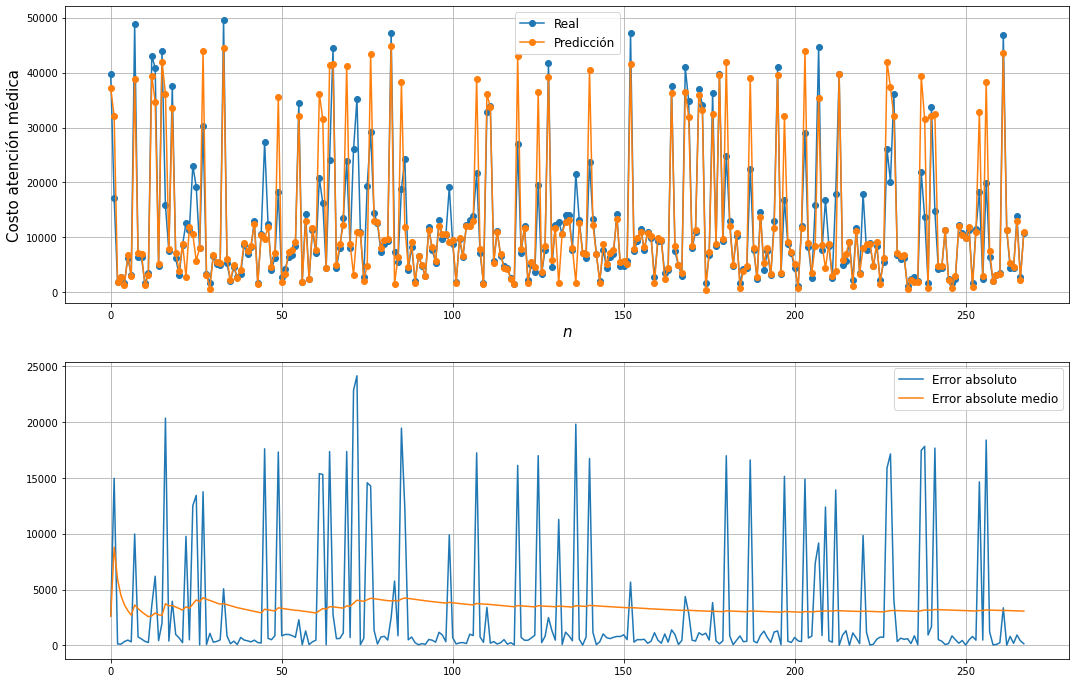

In [28]:
helper.plot_linear_regression_result(
    y_test.to_numpy(), 
    model.predict(x_test), 
    result_label='Costo atención médica'
)

## 4.2 Prueba #2
Esta es la prueba conceptual #2 para ganar intuición con el uso de los métodos, herramientas, entre otros aspectos.
* Modelo: **Regresión Lineal**
* Optimizador: **Stochastic Gradient Descent**
* Función de costo: **Mean Absolute Error**
* Learning Rate: **Step decay**

In [29]:
# Create the sequential stack of dense layers as a model
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_shape=(df_x.shape[1],)))

# Compiling the model with Keras
model.compile(
    optimizer=keras.optimizers.SGD(), 
    loss=keras.losses.MAE
)

# Creating the Learning Rate Scheduler
lr_callback = keras.callbacks.LearningRateScheduler(learningrate.StepDecay(10000, 0.5, 10))

# Create the callback for the TensorBoard
tb_callback = keras.callbacks.TensorBoard(
    log_dir='logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 
    update_freq=1, 
    histogram_freq=1
)

# Create the callback for the EarlyStopping
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=30,
    min_delta=5,
    verbose=1
)

# Create the callback for the ModelCheckpoint
mc_callback = keras.callbacks.ModelCheckpoint('linear_regression_step_decay.h5')

# Training the model
history = model.fit(
    x_train, y_train, validation_data=(x_valid, y_valid), epochs=100, batch_size=64, 
    verbose=2, shuffle=True, 
    callbacks=[
        tb_callback, 
        es_callback,
        lr_callback,
        mc_callback
    ]
)

Epoch 1/100
12/12 - 2s - loss: 13032.4658 - val_loss: 11477.7539
Epoch 2/100
12/12 - 0s - loss: 12669.9482 - val_loss: 13021.1387
Epoch 3/100
12/12 - 0s - loss: 11783.6543 - val_loss: 9363.4375
Epoch 4/100
12/12 - 0s - loss: 11291.0801 - val_loss: 14251.1357
Epoch 5/100
12/12 - 0s - loss: 12626.0107 - val_loss: 5861.4526
Epoch 6/100
12/12 - 0s - loss: 11730.9736 - val_loss: 10514.8516
Epoch 7/100
12/12 - 0s - loss: 12361.5498 - val_loss: 7015.9844
Epoch 8/100
12/12 - 0s - loss: 11644.6543 - val_loss: 13161.7061
Epoch 9/100
12/12 - 0s - loss: 11940.8994 - val_loss: 15478.1543
Epoch 10/100
12/12 - 0s - loss: 12445.3711 - val_loss: 11977.7822
Epoch 11/100
12/12 - 0s - loss: 6691.8579 - val_loss: 9304.7363
Epoch 12/100
12/12 - 0s - loss: 6821.1963 - val_loss: 6125.2402
Epoch 13/100
12/12 - 0s - loss: 6269.5830 - val_loss: 8195.8633
Epoch 14/100
12/12 - 0s - loss: 6385.9697 - val_loss: 4874.1816
Epoch 15/100
12/12 - 0s - loss: 6420.7134 - val_loss: 4122.2642
Epoch 16/100
12/12 - 0s - loss: 

In [30]:
# Load the best model saved
model = keras.models.load_model('linear_regression_step_decay.h5')

In [31]:
# Evaluate the model
train_mae = model.evaluate(x_train, y_train, verbose=0)
test_mae = model.evaluate(x_test, y_test, verbose=0)
print(f'Train: {train_mae}, Test: {test_mae}')

Train: 3741.959716796875, Test: 3077.2314453125


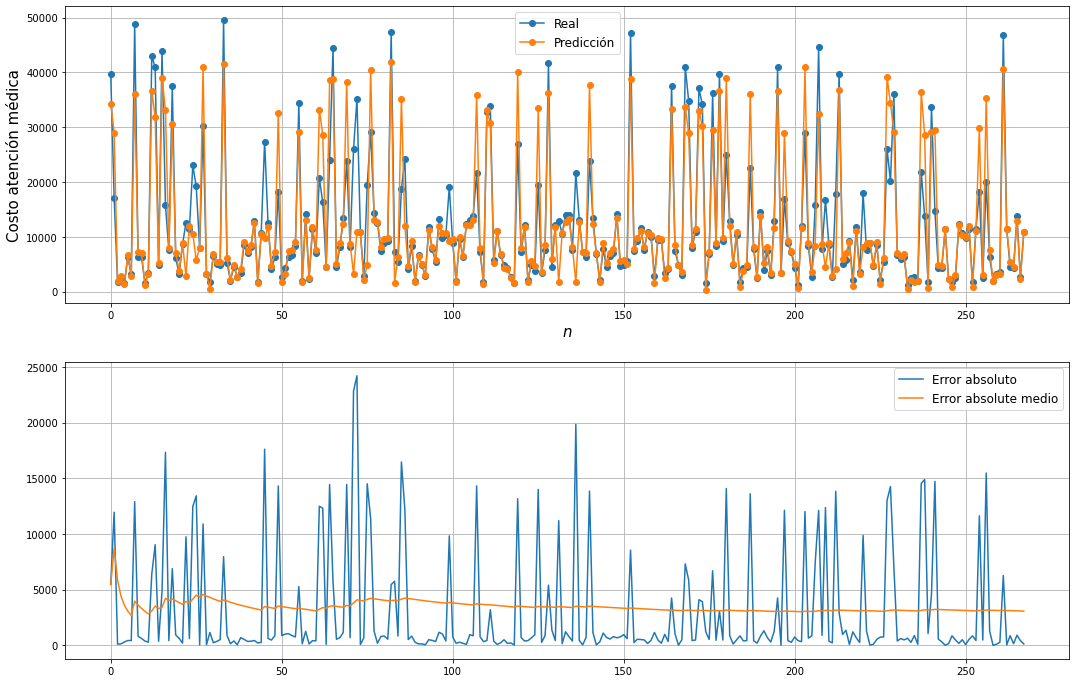

In [32]:
helper.plot_linear_regression_result(
    y_test.to_numpy(), 
    model.predict(x_test), 
    result_label='Costo atención médica'
)

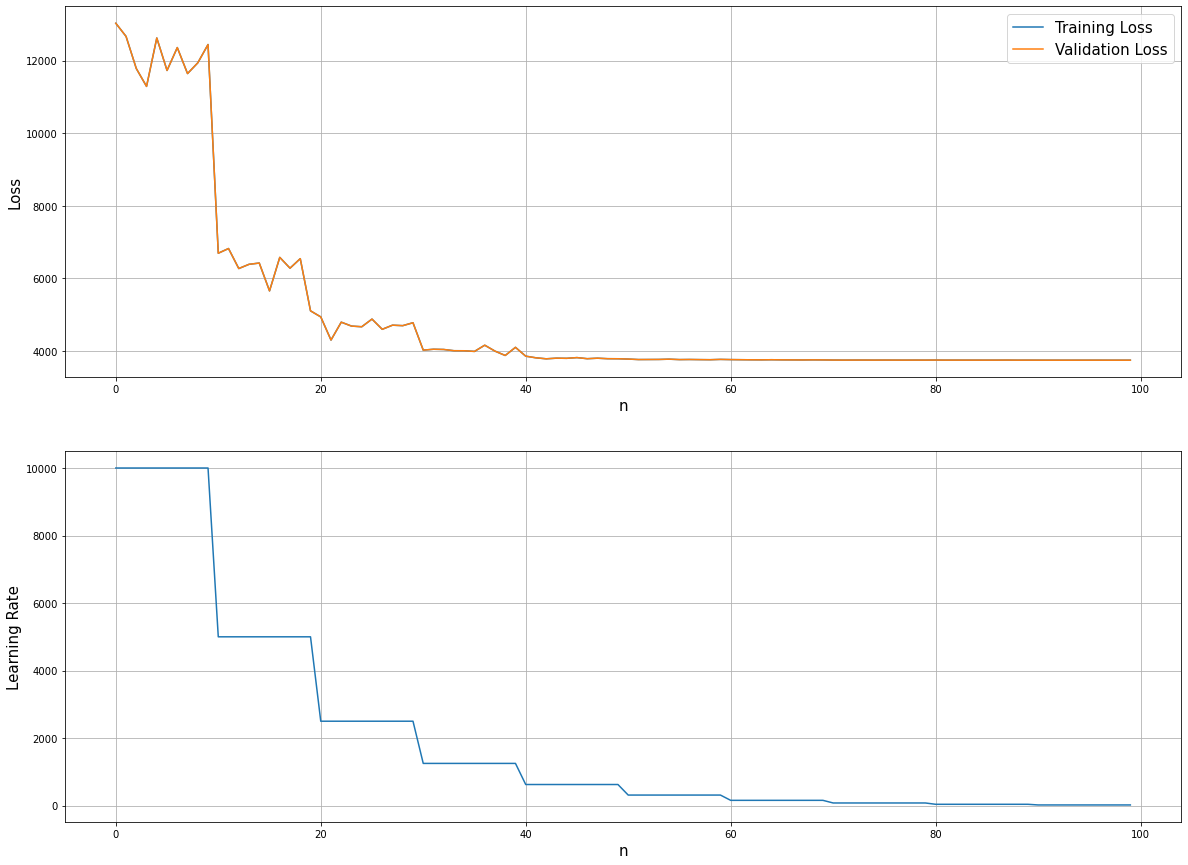

In [33]:
helper.plot_linear_regression_history(history)

## 4.3 Prueba #3
Esta es la prueba conceptual #2 para ganar intuición con el uso de los métodos, herramientas, entre otros aspectos.
* Modelo: **Regresión Lineal**
* Optimizador: **Stochastic Gradient Descent**
* Función de costo: **Mean Absolute Error**
* Learning Rate: **Exponential decay**

In [34]:
# Create the sequential stack of dense layers as a model
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_shape=(df_x.shape[1],)))

# Compiling the model with Keras
model.compile(
    optimizer=keras.optimizers.SGD(), 
    loss=keras.losses.MAE
)

# Creating the Learning Rate Scheduler
lr_callback = keras.callbacks.LearningRateScheduler(learningrate.ExponentialDecay(10000, 0.07))

# Create the callback for the TensorBoard
tb_callback = keras.callbacks.TensorBoard(
    log_dir='logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 
    update_freq=1, 
    histogram_freq=1
)

# Create the callback for the EarlyStopping
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=30,
    min_delta=1,
    verbose=1
)

# Create the callback for the ModelCheckpoint
mc_callback = keras.callbacks.ModelCheckpoint('linear_regression_exponential_decay.h5')

# Training the model
history = model.fit(
    x_train, y_train, validation_data=(x_valid, y_valid), epochs=100, batch_size=64, 
    verbose=2, shuffle=True, 
    callbacks=[
        tb_callback,
        es_callback,
        lr_callback,
        mc_callback
    ]
)

Epoch 1/100
12/12 - 2s - loss: 12056.1279 - val_loss: 7327.3745
Epoch 2/100
12/12 - 0s - loss: 11138.2656 - val_loss: 8028.7681
Epoch 3/100
12/12 - 0s - loss: 10577.5352 - val_loss: 8710.5068
Epoch 4/100
12/12 - 0s - loss: 10092.5156 - val_loss: 10972.9443
Epoch 5/100
12/12 - 0s - loss: 8423.5098 - val_loss: 9126.2725
Epoch 6/100
12/12 - 0s - loss: 8350.4033 - val_loss: 5256.3184
Epoch 7/100
12/12 - 0s - loss: 7265.1187 - val_loss: 7144.8062
Epoch 8/100
12/12 - 0s - loss: 7443.2988 - val_loss: 6040.4443
Epoch 9/100
12/12 - 0s - loss: 7167.6963 - val_loss: 10858.5156
Epoch 10/100
12/12 - 0s - loss: 6131.6943 - val_loss: 6957.7524
Epoch 11/100
12/12 - 0s - loss: 6313.1050 - val_loss: 5034.6133
Epoch 12/100
12/12 - 0s - loss: 5914.6147 - val_loss: 4600.7627
Epoch 13/100
12/12 - 0s - loss: 5609.5347 - val_loss: 4928.5386
Epoch 14/100
12/12 - 0s - loss: 5619.3198 - val_loss: 6251.1519
Epoch 15/100
12/12 - 0s - loss: 5271.5347 - val_loss: 6920.1758
Epoch 16/100
12/12 - 0s - loss: 4963.4575 -

In [35]:
# Load the best model saved
model = keras.models.load_model('linear_regression_exponential_decay.h5')

In [36]:
# Evaluate the model
train_mae = model.evaluate(x_train, y_train, verbose=0)
test_mae = model.evaluate(x_test, y_test, verbose=0)
print(f'Train: {train_mae}, Test: {test_mae}')

Train: 3734.610107421875, Test: 3075.421142578125


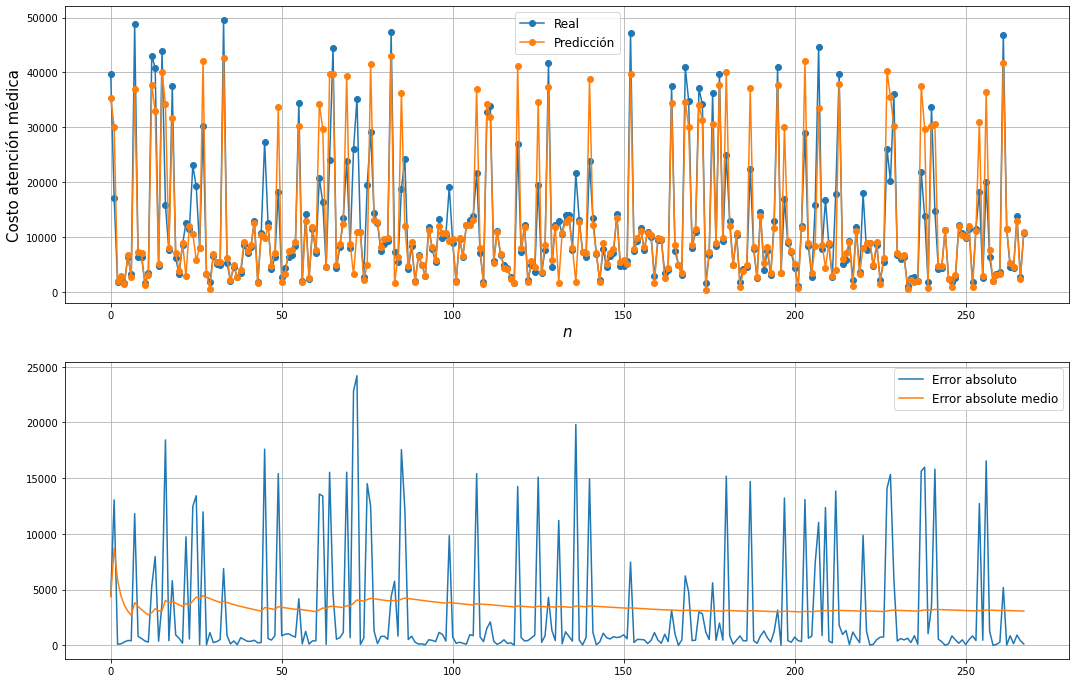

In [37]:
helper.plot_linear_regression_result(
    y_test.to_numpy(), 
    model.predict(x_test), 
    result_label='Costo atención médica'
)

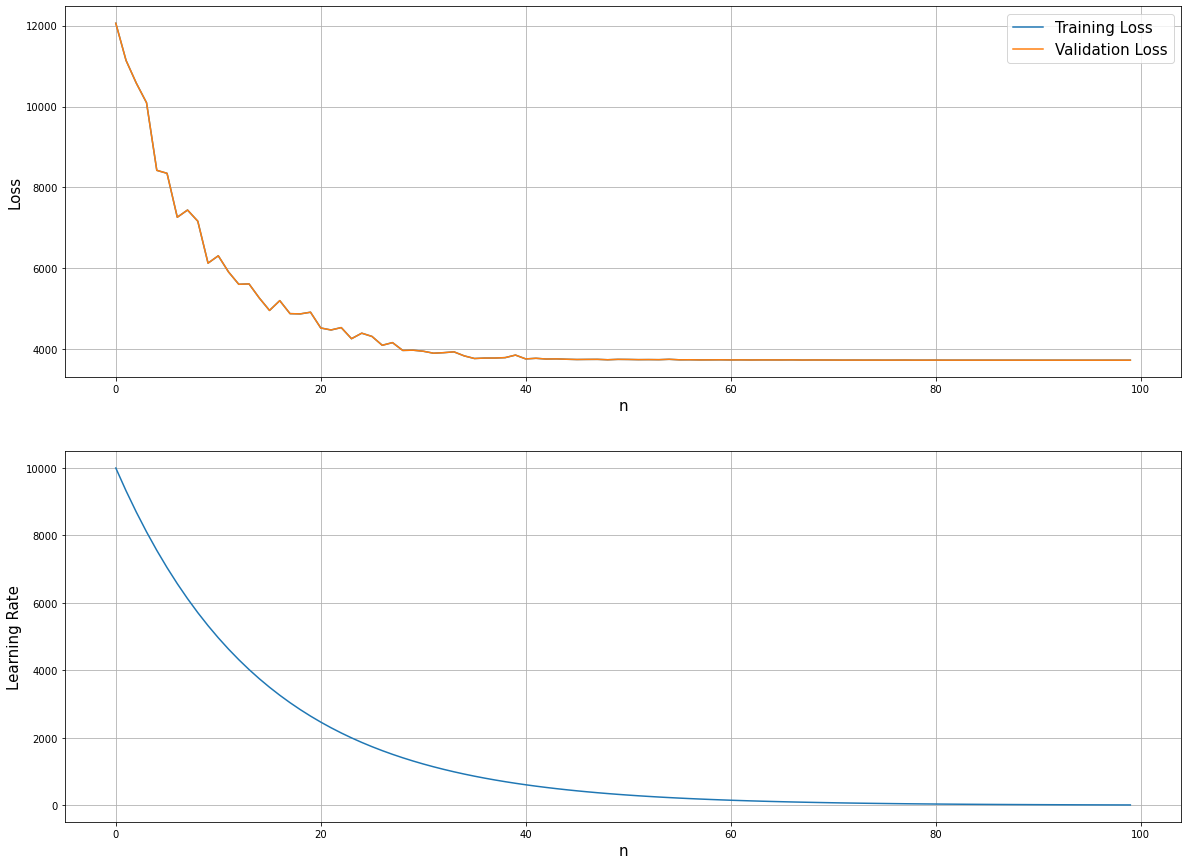

In [38]:
helper.plot_linear_regression_history(history)

## 4.4 Prueba #4
Esta es la prueba conceptual #4 para ganar intuición con el uso de los métodos, herramientas, entre otros aspectos.
* Modelo: **Regresión Lineal**
* Optimizador: **Stochastic Gradient Descent**
* Función de costo: **Mean Absolute Error**
* Learning Rate: **Exponential decay**
* Feature Engineering: **Polynomial Features 2° Degree**

In [39]:
# Creating the polynomial feature preprocessor
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(x_train)

# Create the sequential stack of dense layers as a model
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_shape=(poly.n_output_features_,)))

# Compiling the model with Keras
model.compile(
    optimizer=keras.optimizers.SGD(), 
    loss=keras.losses.MAE
)
print(f'Using {len(model.get_weights()[0])} polynomial features counting the bias')

# Creating the Learning Rate Scheduler
lr_callback = keras.callbacks.LearningRateScheduler(learningrate.ExponentialDecay(5000, 0.09))

# Create the callback for the TensorBoard
tb_callback = keras.callbacks.TensorBoard(
    log_dir='logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 
    update_freq=1, 
    histogram_freq=1
)

# Create the callback for the EarlyStopping
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=30,
    min_delta=10,
    verbose=1
)

# Create the callback for the ModelCheckpoint
mc_callback = keras.callbacks.ModelCheckpoint('linear_regression_polynomial_features_2.h5')

# Training the model
history = model.fit(
    poly.transform(x_train), y_train, validation_data=(poly.transform(x_valid), y_valid), epochs=200, batch_size=64, 
    verbose=2, shuffle=True, 
    callbacks=[
        tb_callback,
        es_callback,
        lr_callback,
        mc_callback
    ]
)

Using 54 polynomial features counting the bias
Epoch 1/200
12/12 - 2s - loss: 28890.9004 - val_loss: 20452.9570
Epoch 2/200
12/12 - 0s - loss: 27437.1855 - val_loss: 40525.7891
Epoch 3/200
12/12 - 0s - loss: 26718.8926 - val_loss: 35127.9609
Epoch 4/200
12/12 - 0s - loss: 21140.2031 - val_loss: 40897.8906
Epoch 5/200
12/12 - 0s - loss: 20960.1582 - val_loss: 16401.7207
Epoch 6/200
12/12 - 0s - loss: 18370.6426 - val_loss: 9609.9561
Epoch 7/200
12/12 - 0s - loss: 13835.2803 - val_loss: 27319.2344
Epoch 8/200
12/12 - 0s - loss: 14812.0332 - val_loss: 18105.9512
Epoch 9/200
12/12 - 0s - loss: 14976.5635 - val_loss: 18364.6660
Epoch 10/200
12/12 - 0s - loss: 12614.3994 - val_loss: 8711.5312
Epoch 11/200
12/12 - 0s - loss: 11568.0439 - val_loss: 14313.3955
Epoch 12/200
12/12 - 0s - loss: 12162.5918 - val_loss: 11036.2520
Epoch 13/200
12/12 - 0s - loss: 11124.2217 - val_loss: 10634.8662
Epoch 14/200
12/12 - 0s - loss: 10065.1592 - val_loss: 6369.0317
Epoch 15/200
12/12 - 0s - loss: 7861.1475

In [40]:
# Load the best model saved
model = keras.models.load_model('linear_regression_polynomial_features_2.h5')

In [41]:
# Evaluate the model
train_mae = model.evaluate(poly.transform(x_train), y_train, verbose=0)
test_mae = model.evaluate(poly.transform(x_test), y_test, verbose=0)
print(f'Train: {train_mae}, Test: {test_mae}')

Train: 2300.6005859375, Test: 1648.95263671875


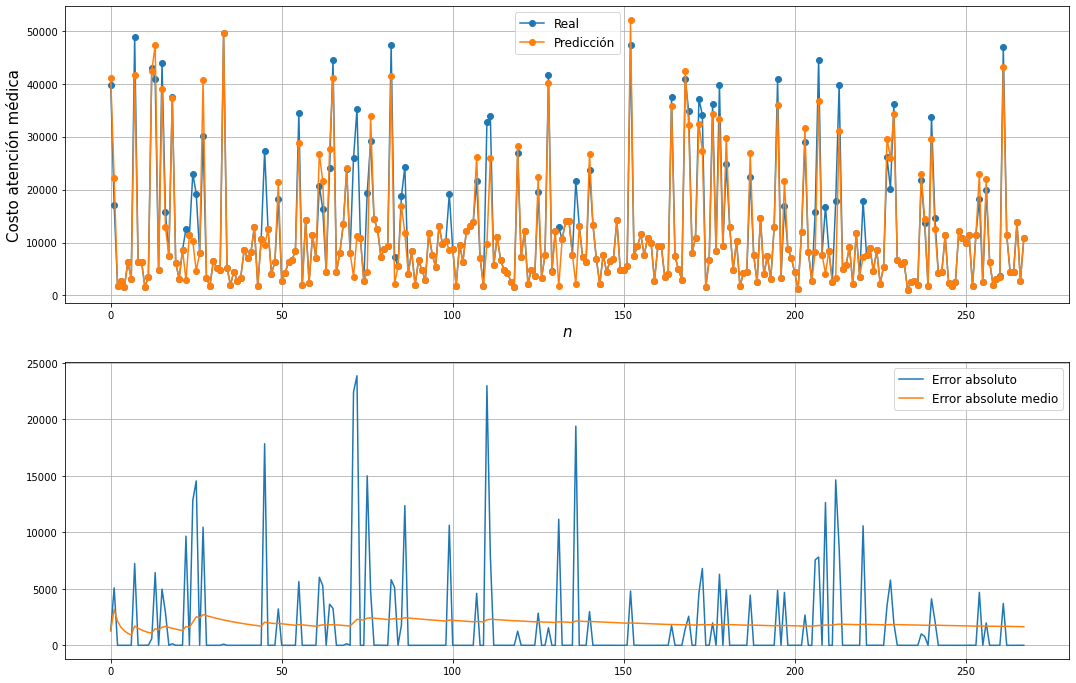

In [42]:
helper.plot_linear_regression_result(
    y_test.to_numpy(), 
    model.predict(poly.transform(x_test)), 
    result_label='Costo atención médica'
)

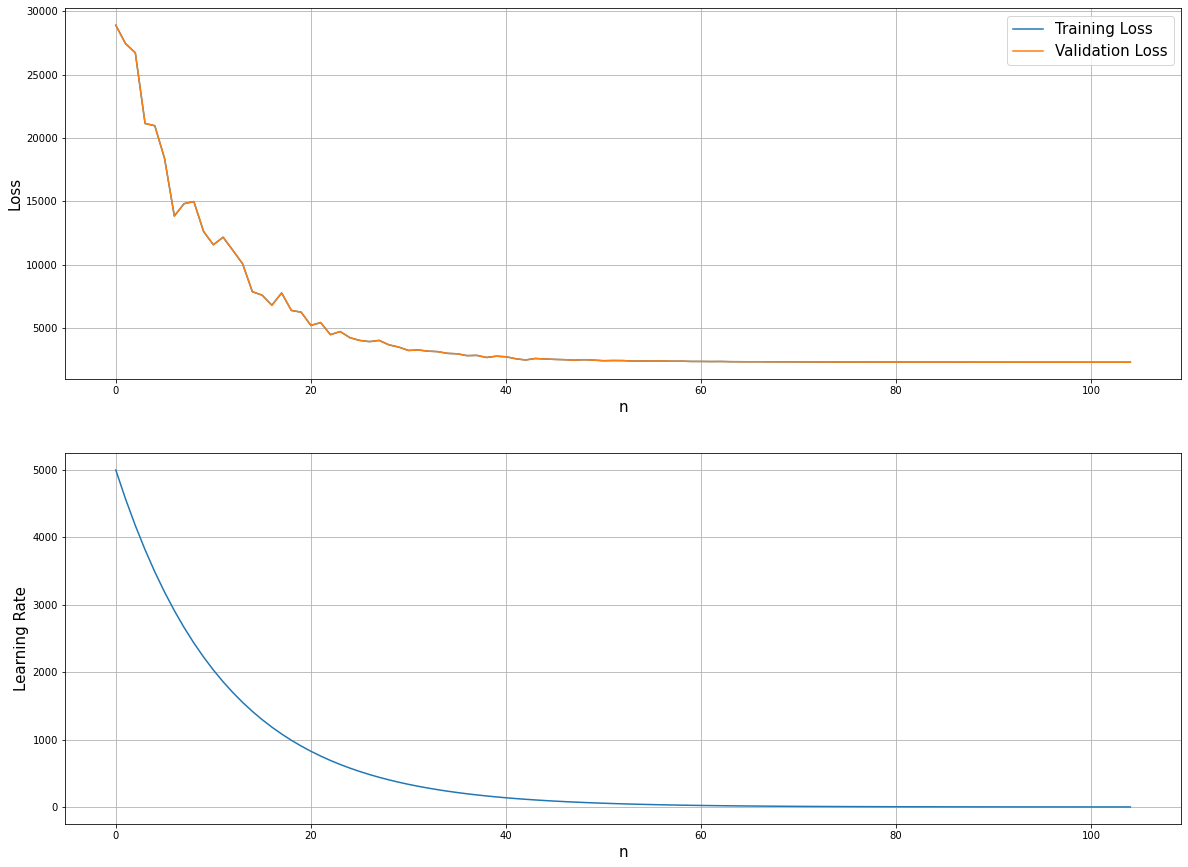

In [43]:
helper.plot_linear_regression_history(history)

## 4.5 Prueba #5
Esta es la prueba conceptual #5 para ganar intuición con el uso de los métodos, herramientas, entre otros aspectos.
* Modelo: **Regresión Lineal**
* Optimizador: **Stochastic Gradient Descent**
* Función de costo: **Mean Absolute Error**
* Learning Rate: **Exponential decay**
* Feature Engineering: **Polynomial Features 3° Degree**

In [44]:
# Creating the polynomial feature preprocessor
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(x_train)

# Create the sequential stack of dense layers as a model
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_shape=(poly.n_output_features_,)))

# Compiling the model with Keras
model.compile(
    optimizer=keras.optimizers.SGD(), 
    loss=keras.losses.MAE
)
print(f'Using {len(model.get_weights()[0])} polynomial features counting the bias')

# Creating the Learning Rate Scheduler
lr_callback = keras.callbacks.LearningRateScheduler(learningrate.ExponentialDecay(5000, 0.1))

# Create the callback for the TensorBoard
tb_callback = keras.callbacks.TensorBoard(
    log_dir='logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 
    update_freq=1, 
    histogram_freq=1
)

# Create the callback for the EarlyStopping
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=50,
    min_delta=10,
    verbose=1
)

# Create the callback for the ModelCheckpoint
mc_callback = keras.callbacks.ModelCheckpoint('linear_regression_polynomial_features_2.h5')

# Training the model
history = model.fit(
    poly.transform(x_train), y_train, validation_data=(poly.transform(x_valid), y_valid), epochs=1000, batch_size=64, 
    verbose=2, shuffle=True, 
    callbacks=[
        tb_callback,
        es_callback,
        lr_callback,
        mc_callback
    ]
)

Using 219 polynomial features counting the bias
Epoch 1/1000
12/12 - 2s - loss: 199226.4219 - val_loss: 236991.5000
Epoch 2/1000
12/12 - 0s - loss: 175299.6094 - val_loss: 269612.1250
Epoch 3/1000
12/12 - 0s - loss: 158693.4688 - val_loss: 224798.9844
Epoch 4/1000
12/12 - 0s - loss: 139221.3125 - val_loss: 421375.1562
Epoch 5/1000
12/12 - 0s - loss: 147427.2188 - val_loss: 168764.4688
Epoch 6/1000
12/12 - 0s - loss: 125804.4844 - val_loss: 102266.2969
Epoch 7/1000
12/12 - 0s - loss: 100402.3594 - val_loss: 151258.2344
Epoch 8/1000
12/12 - 0s - loss: 94813.0859 - val_loss: 131799.9375
Epoch 9/1000
12/12 - 0s - loss: 84229.6953 - val_loss: 34470.1914
Epoch 10/1000
12/12 - 0s - loss: 82243.8906 - val_loss: 23961.1523
Epoch 11/1000
12/12 - 0s - loss: 67117.1875 - val_loss: 25484.9375
Epoch 12/1000
12/12 - 0s - loss: 67616.7812 - val_loss: 42743.6250
Epoch 13/1000
12/12 - 0s - loss: 52036.2344 - val_loss: 92608.9766
Epoch 14/1000
12/12 - 0s - loss: 57968.4023 - val_loss: 25500.7969
Epoch 15

In [45]:
# Load the best model saved
model = keras.models.load_model('linear_regression_polynomial_features_2.h5')

In [46]:
# Evaluate the model
train_mae = model.evaluate(poly.transform(x_train), y_train, verbose=0)
test_mae = model.evaluate(poly.transform(x_test), y_test, verbose=0)
print(f'Train: {train_mae}, Test: {test_mae}')

Train: 2851.134765625, Test: 2393.97705078125


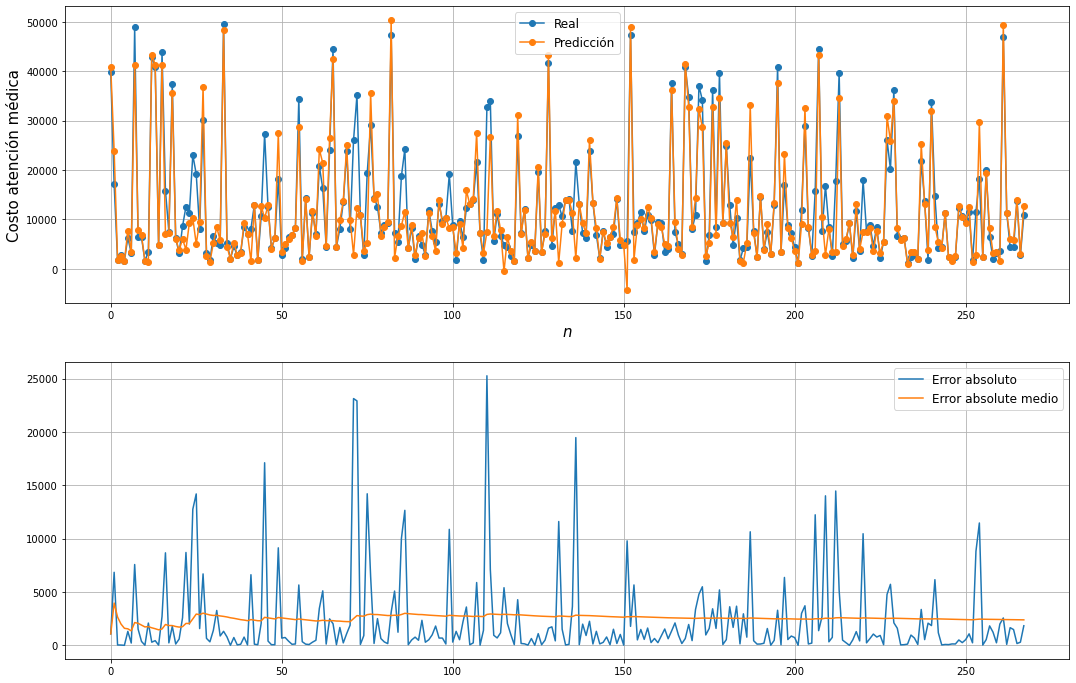

In [47]:
helper.plot_linear_regression_result(
    y_test.to_numpy(), 
    model.predict(poly.transform(x_test)), 
    result_label='Costo atención médica'
)

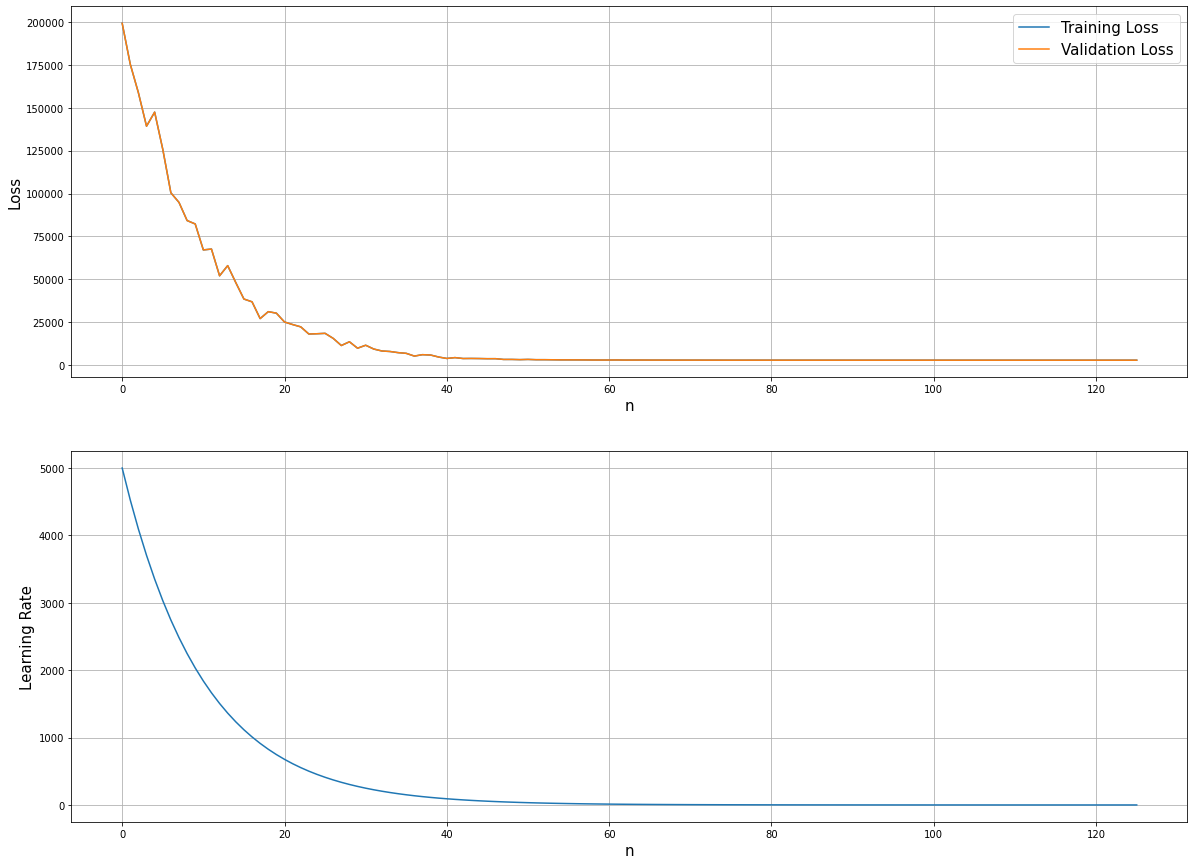

In [48]:
helper.plot_linear_regression_history(history)

## 4.6 Prueba #6
Esta es la prueba conceptual #6 para ganar intuición con el uso de los métodos, herramientas, entre otros aspectos.
* Modelo: **Regresión Lineal**
* Optimizador: **Stochastic Gradient Descent**
* Función de costo: **Mean Absolute Error**
* Learning Rate: **Exponential decay**
* Feature Engineering: **Polynomial Features 4° Degree**

In [49]:
# Creating the polynomial feature preprocessor
poly = preprocessing.PolynomialFeatures(degree=4, include_bias=False)
poly.fit(x_train)

# Create the sequential stack of dense layers as a model
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_shape=(poly.n_output_features_,)))

# Compiling the model with Keras
model.compile(
    optimizer=keras.optimizers.SGD(), 
    loss=keras.losses.MAE
)
print(f'Using {len(model.get_weights()[0])} polynomial features counting the bias')

# Creating the Learning Rate Scheduler
lr_callback = keras.callbacks.LearningRateScheduler(learningrate.ExponentialDecay(1000, 0.1))

# Create the callback for the TensorBoard
tb_callback = keras.callbacks.TensorBoard(
    log_dir='logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 
    update_freq=1, 
    histogram_freq=1
)

# Create the callback for the EarlyStopping
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=50,
    min_delta=10,
    verbose=1
)

# Create the callback for the ModelCheckpoint
mc_callback = keras.callbacks.ModelCheckpoint('linear_regression_polynomial_features_2.h5')

# Training the model
history = model.fit(
    poly.transform(x_train), y_train, validation_data=(poly.transform(x_valid), y_valid), epochs=1000, batch_size=64, 
    verbose=2, shuffle=True, 
    callbacks=[
        tb_callback,
        es_callback,
        lr_callback,
        mc_callback
    ]
)

Using 714 polynomial features counting the bias
Epoch 1/1000
12/12 - 2s - loss: 473102.0000 - val_loss: 218351.0312
Epoch 2/1000
12/12 - 0s - loss: 338083.0312 - val_loss: 119114.1953
Epoch 3/1000
12/12 - 0s - loss: 289366.8438 - val_loss: 304649.5000
Epoch 4/1000
12/12 - 0s - loss: 294952.9375 - val_loss: 777093.4375
Epoch 5/1000
12/12 - 0s - loss: 248407.7188 - val_loss: 782697.2500
Epoch 6/1000
12/12 - 0s - loss: 271210.9062 - val_loss: 141175.2969
Epoch 7/1000
12/12 - 0s - loss: 237131.5156 - val_loss: 279143.4375
Epoch 8/1000
12/12 - 0s - loss: 224489.7031 - val_loss: 66537.0234
Epoch 9/1000
12/12 - 0s - loss: 196154.5781 - val_loss: 67164.0156
Epoch 10/1000
12/12 - 0s - loss: 159585.7031 - val_loss: 256800.6406
Epoch 11/1000
12/12 - 0s - loss: 159487.7500 - val_loss: 77269.9844
Epoch 12/1000
12/12 - 0s - loss: 129404.1953 - val_loss: 69976.8281
Epoch 13/1000
12/12 - 0s - loss: 128729.8828 - val_loss: 84317.3594
Epoch 14/1000
12/12 - 0s - loss: 107972.9219 - val_loss: 157985.6719


In [50]:
# Load the best model saved
model = keras.models.load_model('linear_regression_polynomial_features_2.h5')

In [51]:
# Evaluate the model
train_mae = model.evaluate(poly.transform(x_train), y_train, verbose=0)
test_mae = model.evaluate(poly.transform(x_test), y_test, verbose=0)
print(f'Train: {train_mae}, Test: {test_mae}')

Train: 3830.930908203125, Test: 4058.0322265625


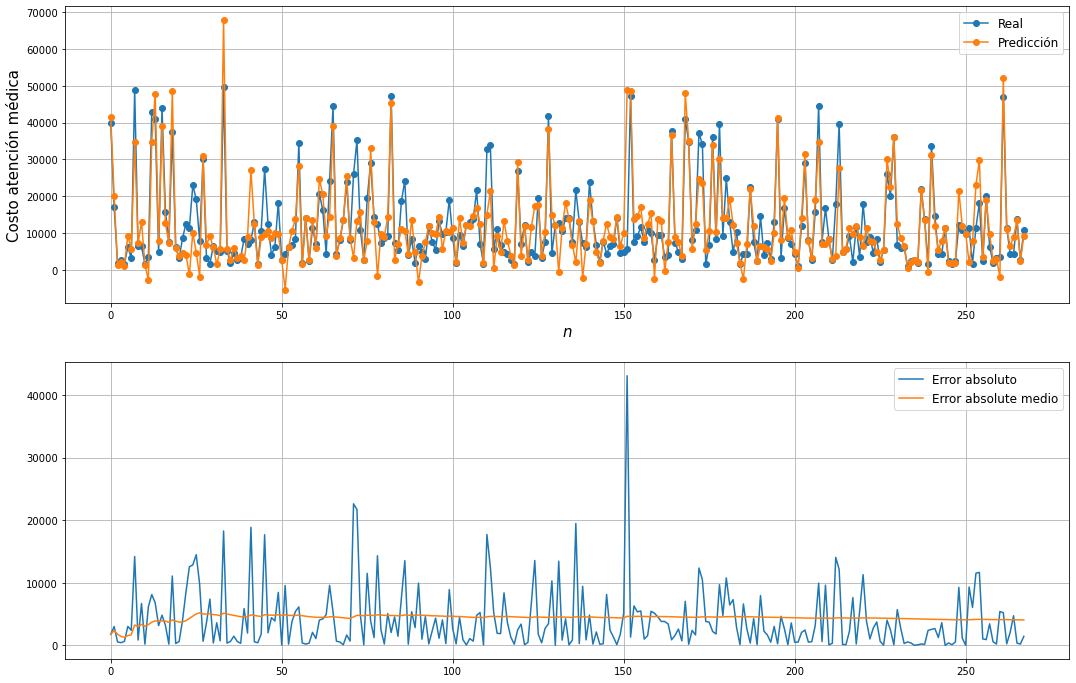

In [52]:
helper.plot_linear_regression_result(
    y_test.to_numpy(), 
    model.predict(poly.transform(x_test)), 
    result_label='Costo atención médica'
)

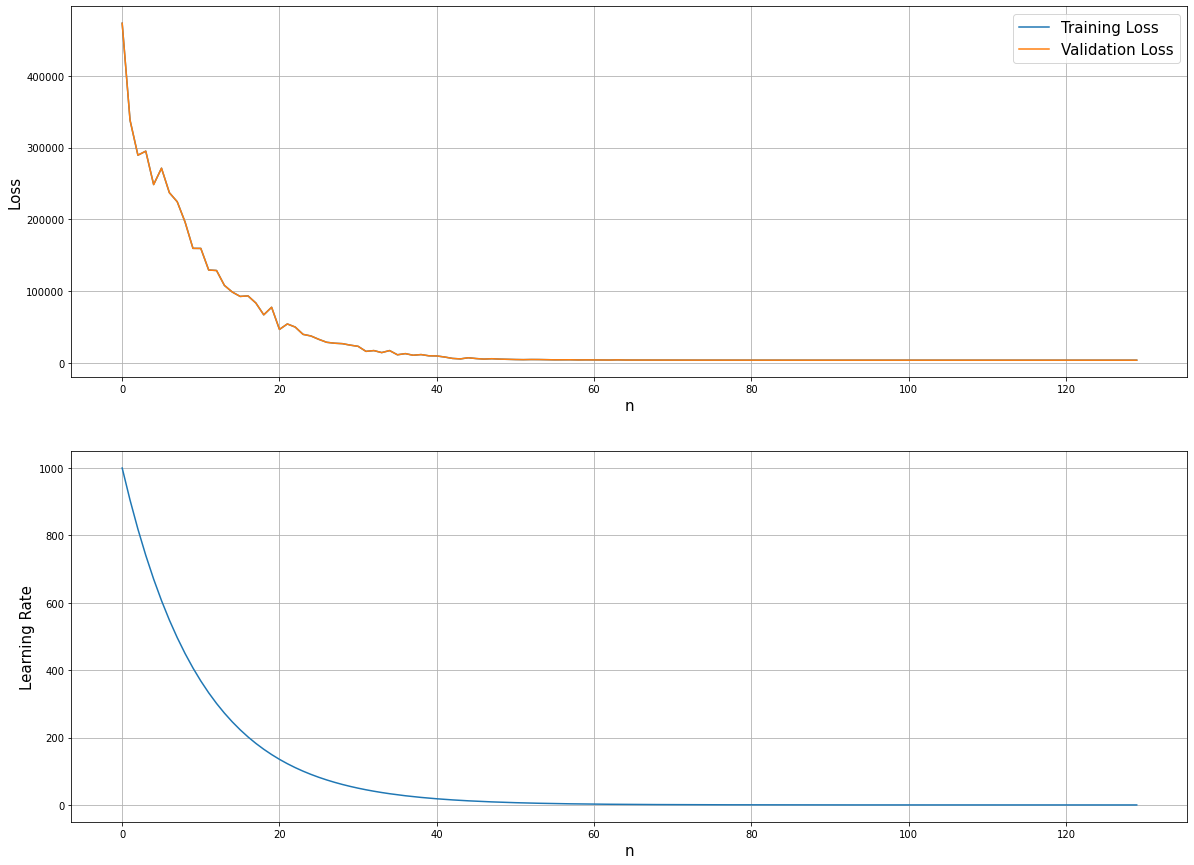

In [53]:
helper.plot_linear_regression_history(history)

## 4.7 Prueba #7
Esta es la prueba conceptual #7 para ganar intuición con el uso de los métodos, herramientas, entre otros aspectos.
* Modelo: **Regresión Lineal**
* Optimizador: **Stochastic Gradient Descent**
* Función de costo: **Mean Square Error**
* Learning Rate: **Exponential decay**

In [54]:
# Create the sequential stack of dense layers as a model
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_shape=(df_x.shape[1],)))

# Compiling the model with Keras
model.compile(
    optimizer=keras.optimizers.SGD(), 
    loss=keras.losses.MSE,
    metrics=keras.losses.MAE
)

# Creating the Learning Rate Scheduler
lr_callback = keras.callbacks.LearningRateScheduler(learningrate.ExponentialDecay(0.1, 0.001))

# Create the callback for the TensorBoard
tb_callback = keras.callbacks.TensorBoard(
    log_dir='logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 
    update_freq=1, 
    histogram_freq=1
)

# Create the callback for the EarlyStopping
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=30,
    min_delta=1,
    verbose=1
)

# Create the callback for the ModelCheckpoint
mc_callback = keras.callbacks.ModelCheckpoint('linear_regression_exponential_decay.h5')

# Training the model
history = model.fit(
    x_train, y_train, validation_data=(x_valid, y_valid), epochs=100, batch_size=64, 
    verbose=2, shuffle=True,
    callbacks=[
        tb_callback,
        es_callback,
        lr_callback,
        mc_callback
    ]
)

Epoch 1/100
12/12 - 2s - loss: 133927520.0000 - mean_absolute_error: 8081.4912 - val_loss: 80527600.0000 - val_mean_absolute_error: 6755.8208
Epoch 2/100
12/12 - 0s - loss: 66236236.0000 - mean_absolute_error: 5969.5186 - val_loss: 56903584.0000 - val_mean_absolute_error: 5711.2783
Epoch 3/100
12/12 - 0s - loss: 52150568.0000 - mean_absolute_error: 5336.8066 - val_loss: 45975228.0000 - val_mean_absolute_error: 5115.7129
Epoch 4/100
12/12 - 0s - loss: 46538352.0000 - mean_absolute_error: 5145.1685 - val_loss: 41593204.0000 - val_mean_absolute_error: 4230.9580
Epoch 5/100
12/12 - 0s - loss: 43872952.0000 - mean_absolute_error: 4826.6270 - val_loss: 38415432.0000 - val_mean_absolute_error: 4712.4277
Epoch 6/100
12/12 - 0s - loss: 42277532.0000 - mean_absolute_error: 4731.8267 - val_loss: 37292416.0000 - val_mean_absolute_error: 4745.2163
Epoch 7/100
12/12 - 0s - loss: 42188480.0000 - mean_absolute_error: 4721.7476 - val_loss: 35161544.0000 - val_mean_absolute_error: 4319.7241
Epoch 8/100


In [55]:
# Load the best model saved
model = keras.models.load_model('linear_regression_exponential_decay.h5')

In [56]:
# Evaluate the model
train_mae = model.evaluate(x_train, y_train, verbose=0)[1]
test_mae = model.evaluate(x_test, y_test, verbose=0)[1]
print(f'Train: {train_mae}, Test: {test_mae}')

Train: 4376.0419921875, Test: 3832.380859375


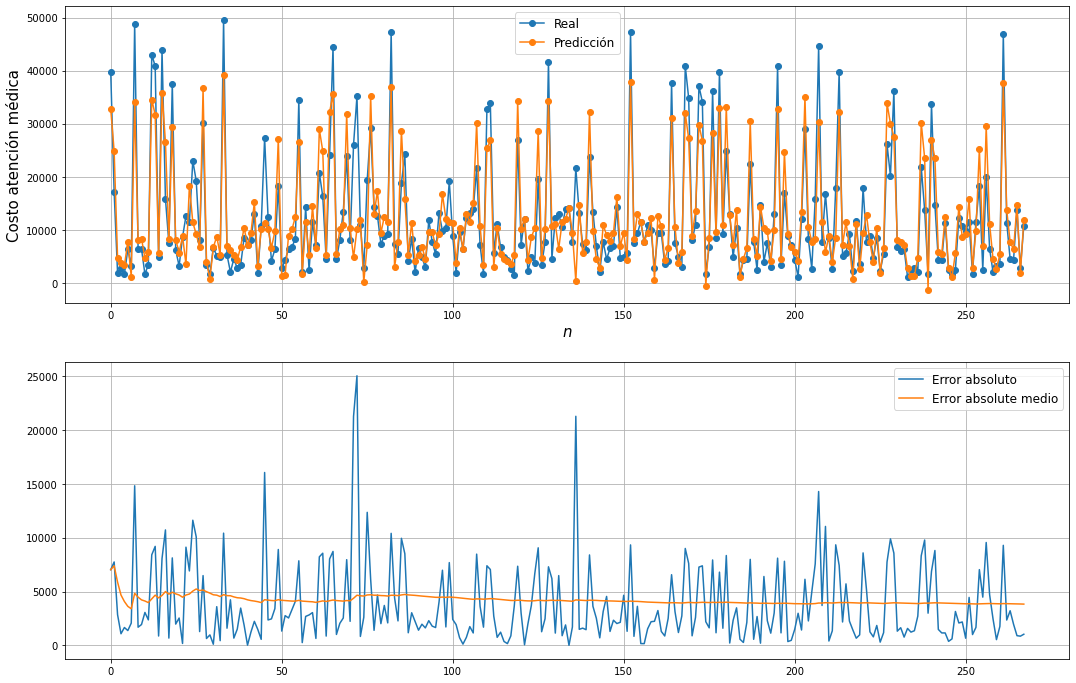

In [57]:
helper.plot_linear_regression_result(
    y_test.to_numpy(), 
    model.predict(x_test), 
    result_label='Costo atención médica'
)

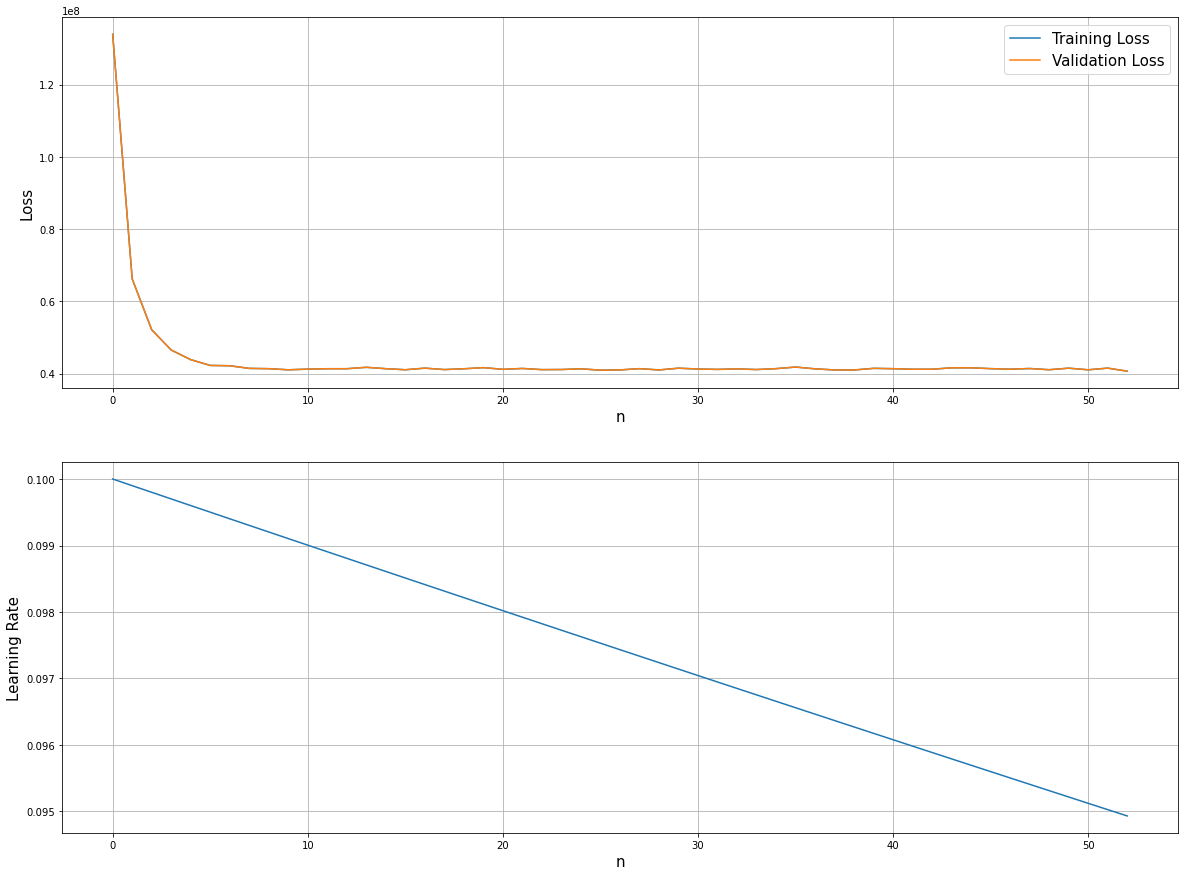

In [58]:
helper.plot_linear_regression_history(history)

## 4.8 Prueba #8
Esta es la prueba conceptual #8 para ganar intuición con el uso de los métodos, herramientas, entre otros aspectos.
* Modelo: **Regresión Lineal**
* Optimizador: **Stochastic Gradient Descent**
* Función de costo: **Mean Square Error**
* Learning Rate: **Exponential decay**
* Feature Engineering: **Polynomial Features 2° Degree**

In [59]:
# Creating the polynomial feature preprocessor
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(x_train)

# Create the sequential stack of dense layers as a model
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_shape=(poly.n_output_features_,)))

# Compiling the model with Keras
model.compile(
    optimizer=keras.optimizers.SGD(), 
    loss=keras.losses.MSE,
    metrics=keras.losses.MAE
)
print(f'Using {len(model.get_weights()[0])} polynomial features counting the bias')

# Creating the Learning Rate Scheduler
lr_callback = keras.callbacks.LearningRateScheduler(learningrate.ExponentialDecay(0.01, 0.0001))

# Create the callback for the TensorBoard
tb_callback = keras.callbacks.TensorBoard(
    log_dir='logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 
    update_freq=1, 
    histogram_freq=1
)

# Create the callback for the EarlyStopping
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=30,
    min_delta=10,
    verbose=1
)

# Create the callback for the ModelCheckpoint
mc_callback = keras.callbacks.ModelCheckpoint('linear_regression_polynomial_features_2.h5')

# Training the model
history = model.fit(
    poly.transform(x_train), y_train, validation_data=(poly.transform(x_valid), y_valid), epochs=200, batch_size=64, 
    verbose=2, shuffle=True, 
    callbacks=[
        tb_callback,
        es_callback,
        lr_callback,
        mc_callback
    ]
)

Using 54 polynomial features counting the bias
Epoch 1/200
12/12 - 2s - loss: 195601792.0000 - mean_absolute_error: 9405.9648 - val_loss: 137912960.0000 - val_mean_absolute_error: 8019.8472
Epoch 2/200
12/12 - 0s - loss: 114051288.0000 - mean_absolute_error: 7300.7231 - val_loss: 96250592.0000 - val_mean_absolute_error: 6749.6665
Epoch 3/200
12/12 - 0s - loss: 89461168.0000 - mean_absolute_error: 6554.6768 - val_loss: 78467152.0000 - val_mean_absolute_error: 6038.5469
Epoch 4/200
12/12 - 0s - loss: 75458264.0000 - mean_absolute_error: 6040.2764 - val_loss: 66932972.0000 - val_mean_absolute_error: 5611.1943
Epoch 5/200
12/12 - 0s - loss: 66000824.0000 - mean_absolute_error: 5632.9565 - val_loss: 58690116.0000 - val_mean_absolute_error: 5208.0181
Epoch 6/200
12/12 - 0s - loss: 59727220.0000 - mean_absolute_error: 5300.0420 - val_loss: 52235324.0000 - val_mean_absolute_error: 5059.9263
Epoch 7/200
12/12 - 0s - loss: 54496056.0000 - mean_absolute_error: 5077.1514 - val_loss: 47494568.0000 

In [60]:
# Load the best model saved
model = keras.models.load_model('linear_regression_polynomial_features_2.h5')

In [61]:
# Evaluate the model
train_mae = model.evaluate(poly.transform(x_train), y_train, verbose=0)[1]
test_mae = model.evaluate(poly.transform(x_test), y_test, verbose=0)[1]
print(f'Train: {train_mae}, Test: {test_mae}')

Train: 3407.2861328125, Test: 3056.80419921875


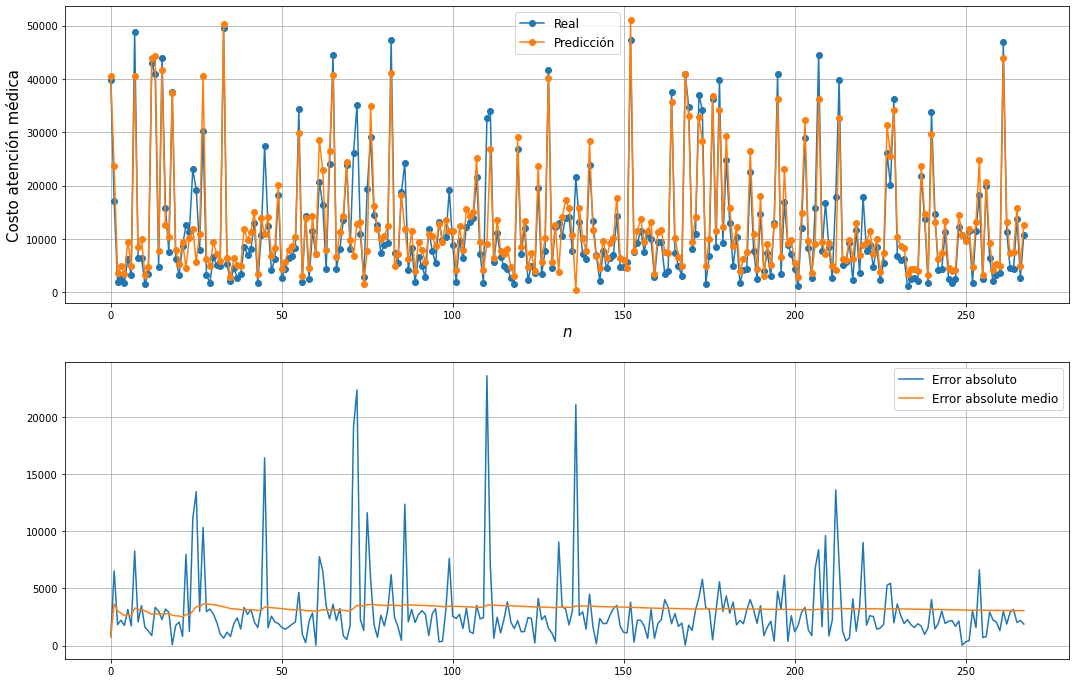

In [62]:
helper.plot_linear_regression_result(
    y_test.to_numpy(), 
    model.predict(poly.transform(x_test)), 
    result_label='Costo atención médica'
)

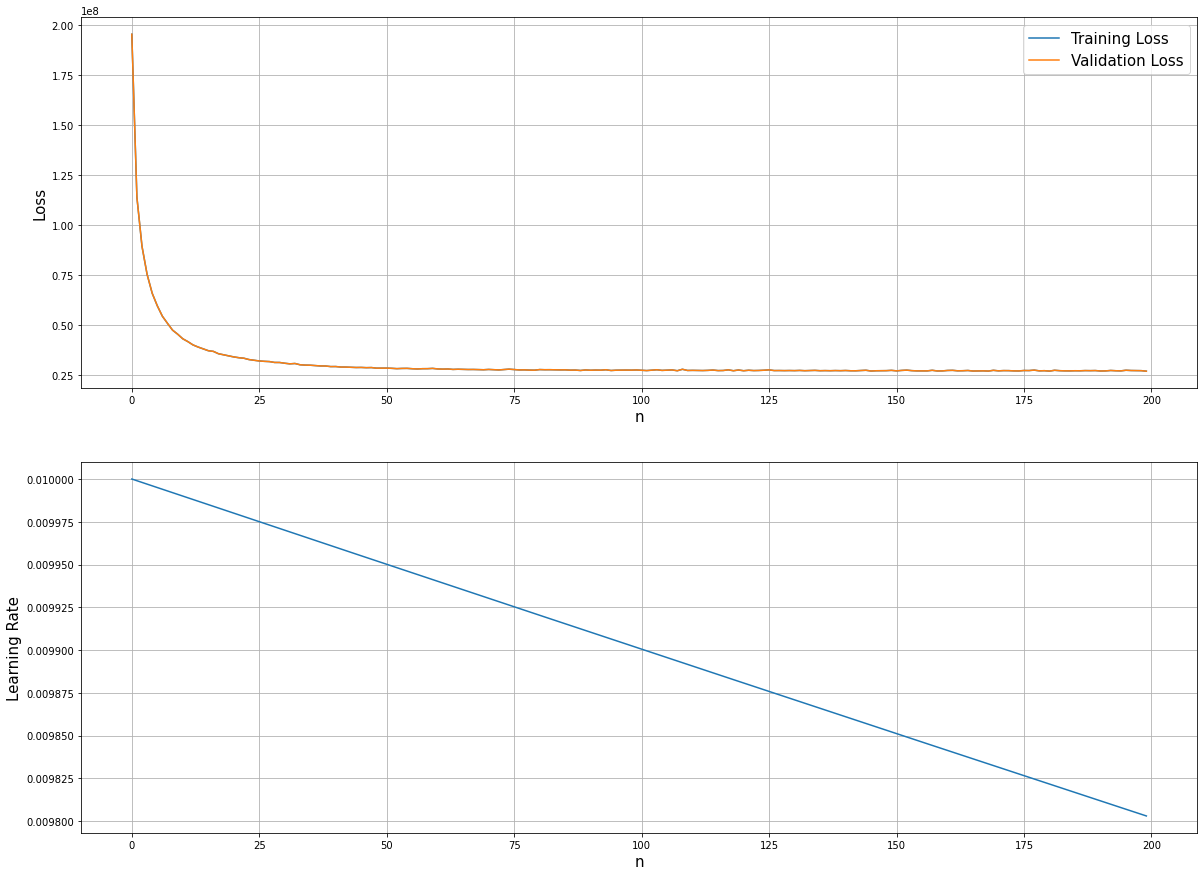

In [63]:
helper.plot_linear_regression_history(history)